# Level 2 - Feature Detection in Bladder Cancer Proteomics

This notebook identifies protein features that distinguish the 7 patient subpopulations discovered in Level 1. We use the provided cluster/stage annotations (Subtype) and apply supervised feature selection to prioritize discriminative proteins.


Notebook roadmap
- Load and align proteomics data with metadata labels.
- Validate Level 1 clustering vs Subtype using ARI/NMI and a contingency heatmap.
- Preprocess features (log2, z-score, variance filter).
- Select discriminative proteins using ANOVA and Random Forest importance.
- Visualize top features and subtype-level expression patterns.


## 0. Imports and global settings

We load scientific Python libraries, ML utilities, and the course helper modules. Random seeds and plot style are set for reproducibility.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.dimensionality_reduction import apply_pca
from src.bladder_proteomics.clustering import kmeans_cluster

from src.bladder_proteomics.preprocessing import (
    log2_transform,
    zscore_normalize,
    variance_filter,
)
from src.bladder_proteomics.feature_selection import (
    anova_select,
    random_forest_importance,
)
from src.bladder_proteomics.plotting import set_plot_style, plot_heatmap

np.random.seed(42)
set_plot_style(dpi=120)


## 1. Load and align proteomics and metadata

We load the proteomics matrix and the final metadata file, then align samples by patient ID. Subtype is used as the target label for Level 2.


In [2]:
proteomics, metadata = load_data(
    "../data/proteomics.txt",
    "../data/Final_metadata.csv",
    transpose=True
)

# Normalize metadata IDs to match proteomics IDs
metadata.index = metadata.index.astype(str).str.replace(r"^LFQ\.", "", regex=True)

validate_data(proteomics)
validate_data(metadata)

# Align by Patient ID
common_ids = proteomics.index.intersection(metadata.index)
proteomics = proteomics.loc[common_ids]
metadata = metadata.loc[common_ids]

labels = metadata["Subtype"].astype(str)
label_order = ["Tis", "Ta", "T1", "T2a", "T2b", "T3", "T4"]
labels = pd.Categorical(labels, categories=label_order, ordered=True)
label_codes = labels.codes

print(f"Number of patients after alignment: {len(common_ids)}")
print(labels.value_counts().sort_index())


Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Data shape (samples × features): (140, 14)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Number of patients after alignment: 140
Tis    20
Ta     20
T1     20
T2a    20
T2b    20
T3     20
T4     20
Name: count, dtype: int64


Label handling
- Subtype is converted to an ordered categorical variable.
- Codes (0-6) are used for modeling, while the ordered labels are used for plots.


## 1.1 Validation - cluster vs Subtype agreement

We re-run a simple KMeans (k=7) on a PCA embedding and compare the clusters to Subtype labels. ARI and NMI quantify agreement; the heatmap shows the cross-tab counts.


In [3]:
# === Reproduce Level 1 clustering (fixed configuration) ===

def select_top_m(X: pd.DataFrame, m: int) -> pd.DataFrame:
    """ Select top m features by variance after log2 transformation.
    Args:
        X: DataFrame with features.
        m: Number of top features to select.
    Returns:
        DataFrame with top m features."""   
    X_log, _ = log2_transform(X) # To stabilize variance and reduce skewness
    var = X_log.var(axis=0)
    top_features = var.sort_values(ascending=False).head(m).index
    return X_log[top_features]
    
# Use the same parameters as Level 1
m_star = 20
n_pc_star = 6
k_star = 7

# Feature selection
X_m = select_top_m(proteomics, m_star)
X_scaled = zscore_normalize(X_m, axis=0)
# PCA
pca_full, _ = apply_pca(X_scaled, n_components=n_pc_star, return_model=True)
# Clustering
cluster_labels = kmeans_cluster( pca_full, n_clusters=k_star, align_labels=True)
# Ensure alignment
subtype_codes = label_codes[pca_full.index.get_indexer(metadata.index)]
# Compute ARI
ari = adjusted_rand_score(subtype_codes, cluster_labels)

print(f"Adjusted Rand Index (Clustering vs Subtype): {ari:.3f}")


Adjusted Rand Index (Clustering vs Subtype): 1.000


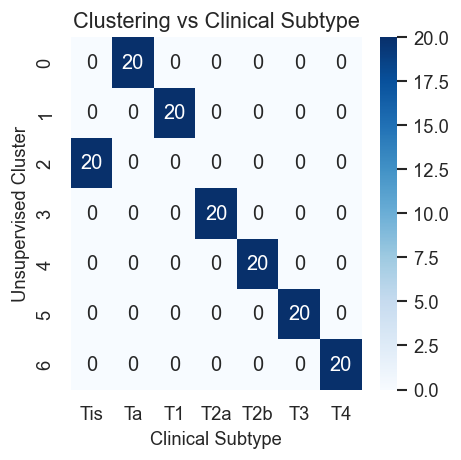

In [4]:
# Heatmap: Clustering vs Subtype (Level 1 validation)

# Build contingency table
ct = pd.crosstab(
    cluster_labels,
    metadata.loc[pca_full.index, "Subtype"]
)

# Reorder columns by biological stage
ct = ct[label_order]

# Plot heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(
    ct,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Clinical Subtype")
plt.ylabel("Unsupervised Cluster")
plt.title("Clustering vs Clinical Subtype")
plt.tight_layout()
plt.show()


## 2. Feature selection pipeline

After validating the patient subpopulations in Level 1, we focus on identifying proteins that best explain the observed subtype structure.  
The goal of this stage is to **interpret and characterize the established subtypes** using proteomic features.

### Design Elements

The feature selection pipeline is designed to be data-driven, interpretable, and robust:

- **Log2 transformation** is applied to stabilize variance and reduce skewness in protein expression.
- **Z-score normalization** is performed per protein to ensure comparability across patients.
- **Variance filtering** is used as an initial noise-reduction step.
- **ANOVA F-test with FDR correction** identifies proteins with statistically significant differences across subtypes.
- **Random Forest feature importance** captures nonlinear and interaction-based discriminative patterns.
- **Final candidate proteins** are selected based on consistency between ANOVA and Random Forest rankings.



## 2.1 Preprocessing

Proteomic intensities are log-transformed and standardized prior to feature selection.  
This ensures that downstream statistical tests and machine learning models are not dominated by scale differences or extreme values.


In [5]:
# Preprocess
X_log, _ = log2_transform(proteomics)
X_scaled = zscore_normalize(X_log, axis=0)

## 2.2 Interpretability Analysis

To identify proteins associated with subtype differences, two complementary criteria are applied:

- ANOVA F-scores quantify mean expression differences across subtypes with FDR correction.

- Random Forest importance scores capture nonlinear contributions to subtype discrimination.

The pipeline ranks proteins independently using both metrics and evaluates their agreement using the **Jaccard index**. 

A variance threshold is selected by maximizing this agreement, ensuring stability across criteria. 

Final proteins are chosen from the consensus of both rankings, balancing statistical significance with predictive relevance.

In [6]:
def benjamini_hochberg(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals, dtype=float)
    n = pvals.size
    order = np.argsort(pvals)
    ranks = np.arange(1, n + 1)
    q = pvals[order] * n / ranks
    q = np.minimum.accumulate(q[::-1])[::-1]
    qvals = np.empty_like(q)
    qvals[order] = q
    return qvals


def jaccard(a, b) -> float:
    a, b = set(a), set(b)
    if len(a | b) == 0:
        return 0.0
    return len(a & b) / len(a | b)


def metric1_metric2_topk(
    X_var: pd.DataFrame,
    y_codes: np.ndarray,
    top_n: int = 20,
    rf_estimators: int = 500,
    random_state: int = 42,
):
    """
    metric1: ANOVA F-score
    metric2: Random Forest importance
    """

    # ---------- Metric 1: ANOVA ----------
    _, _, (metric1_scores, p_values) = anova_select(
        X_var,
        y_codes,
        k="all",
        return_scores=True
    )
    q_values = benjamini_hochberg(p_values)

    table_metric1 = pd.DataFrame({
        "Protein": X_var.columns,
        "Metric1_score": metric1_scores,
        "p_value": p_values,
        "q_value": q_values,
    }).sort_values("Metric1_score", ascending=False)

    top_metric1 = table_metric1.head(top_n)["Protein"].tolist()

    # ---------- Metric 2: Random Forest ----------
    _, _, metric2_scores = random_forest_importance(
        X_var,
        y_codes,
        task="classification",
        n_estimators=rf_estimators,
        random_state=random_state
    )

    table_metric2 = pd.DataFrame({
        "Protein": X_var.columns,
        "Metric2_score": metric2_scores,
    }).sort_values("Metric2_score", ascending=False)

    top_metric2 = table_metric2.head(top_n)["Protein"].tolist()

    J = jaccard(top_metric1, top_metric2)

    return J, table_metric1, table_metric2


def pick_variance_threshold_by_metric_agreement(
    X_scaled: pd.DataFrame,
    y_codes: np.ndarray,
    percentile_grid,
    top_n: int = 20,
    rf_estimators: int = 500,
    random_state: int = 42,
):
    records = []
    tables = {}

    for p in percentile_grid:
        X_var, _ = variance_filter(X_scaled, percentile=p)

        J, table_metric1, table_metric2 = metric1_metric2_topk(
            X_var,
            y_codes,
            top_n=top_n,
            rf_estimators=rf_estimators,
            random_state=random_state
        )

        records.append({
            "percentile": p,
            "jaccard": J
        })

        tables[p] = (table_metric1, table_metric2)

    summary = pd.DataFrame(records)

    # max Jaccard, tie → min percentile
    best_J = summary["jaccard"].max()
    best_p = summary.loc[
        summary["jaccard"] == best_J, "percentile"
    ].max()

    summary = summary.sort_values(
        ["jaccard", "percentile"],
        ascending=[False, True]
    ).reset_index(drop=True)

    return best_p, summary, tables

best_p, summary_df, tables = pick_variance_threshold_by_metric_agreement(
    X_scaled,
    label_codes,
    percentile_grid=[40, 50, 60, 70, 80],
    top_n=20,
    rf_estimators=500,
    random_state=42
)

print("Threshold selection (Metric1 vs Metric2 Jaccard):")
display(summary_df)
print(f"Chosen variance filter percentile: {best_p}")

table_metric1, table_metric2 = tables[best_p]

final_table = (
    table_metric1
    .merge(table_metric2, on="Protein")
    .sort_values("Metric1_score", ascending=False)
    .reset_index(drop=True)
)

print("Final selected proteins (Top 20 by Metric1):")
display(final_table.head(20))


Threshold selection (Metric1 vs Metric2 Jaccard):


,percentile,jaccard
0,40,0.538462
1,50,0.538462
2,60,0.538462
3,70,0.538462
4,80,0.428571


Chosen variance filter percentile: 70
Final selected proteins (Top 20 by Metric1):


,Protein,Metric1_score,p_value,q_value,Metric2_score
0,S100A9,5408.279780,3.040725e-156,6.701759e-153,0.021175
1,CXCR4,3587.418783,1.891721e-144,2.084676e-141,0.015116
2,GADD45A,3099.918814,2.926610e-140,2.150083e-137,0.013374
3,MYC,2767.076529,5.264639e-137,2.900816e-134,0.020538
4,SPP1,2716.515852,1.776495e-136,7.830792e-134,0.027221
5,FOXM1,2298.376728,1.079227e-131,3.964361e-129,0.021633
6,SERPINE1,1427.065878,4.208912e-118,1.325206e-115,0.018989
7,BIRC5,1029.325068,7.668685e-109,2.112723e-106,0.017178
8,FGFR3,900.299733,4.602759e-105,1.127165e-102,0.017409
9,CTNNB1,727.007062,4.651639e-99,1.025221e-96,0.014469


In [7]:
def find_consensus_by_descending_k(
    anova_table: pd.DataFrame,
    rf_table: pd.DataFrame,
    k_start: int = 20,
    jaccard_threshold: float = 0.99,
):
    """
    Starting from k_start, decrease k until
    Jaccard(ANOVA_top_k, RF_top_k) >= threshold.

    Returns:
      k_star, jaccard_value, consensus_proteins
    """
    anova_rank = anova_table["Protein"].tolist()
    rf_rank = rf_table["Protein"].tolist()

    for k in range(k_start, 0, -1):
        A = set(anova_rank[:k])
        R = set(rf_rank[:k])
        J = jaccard(A, R)

        if J >= jaccard_threshold:
            consensus = sorted(A & R)
            return k, J, consensus

    return None, None, []


In [8]:
anova_table, rf_table = tables[best_p]

anova_table = anova_table.rename(
    columns={"Metric1_score": "F_score"}
)
rf_table = rf_table.rename(
    columns={"Metric2_score": "RF_importance"}
)

anova_table = anova_table.sort_values("F_score", ascending=False).reset_index(drop=True)
rf_table = rf_table.sort_values("RF_importance", ascending=False).reset_index(drop=True)


In [9]:
k_star, J_star, consensus_proteins = find_consensus_by_descending_k(
    anova_table,
    rf_table,
    k_start=20,
    jaccard_threshold=0.99
)

if k_star is None:
    print("No k ≤ 20 achieved Jaccard ≥ 0.99. Consider lowering threshold.")
else:
    print(f"Consensus achieved at k = {k_star}")
    print(f"Jaccard = {J_star:.3f}")
    print(f"Number of consensus proteins: {len(consensus_proteins)}")
    print(consensus_proteins)


Consensus achieved at k = 13
Jaccard = 1.000
Number of consensus proteins: 13
['APOE', 'BIRC5', 'CCNB1', 'CTNNB1', 'CXCR4', 'FGFR3', 'FN1', 'FOXM1', 'GADD45A', 'MYC', 'S100A9', 'SERPINE1', 'SPP1']


## 2.3 Visualization

Visualizations are used to assess feature relevance and biological consistency.


### 2.3.1 ANOVA F-score and Random Forest Importance

Bar plots of ANOVA F-scores and Random Forest importance values are used to examine the top-ranked proteins under each metric.  
Agreement between the two rankings provides additional confidence in the selected candidates.


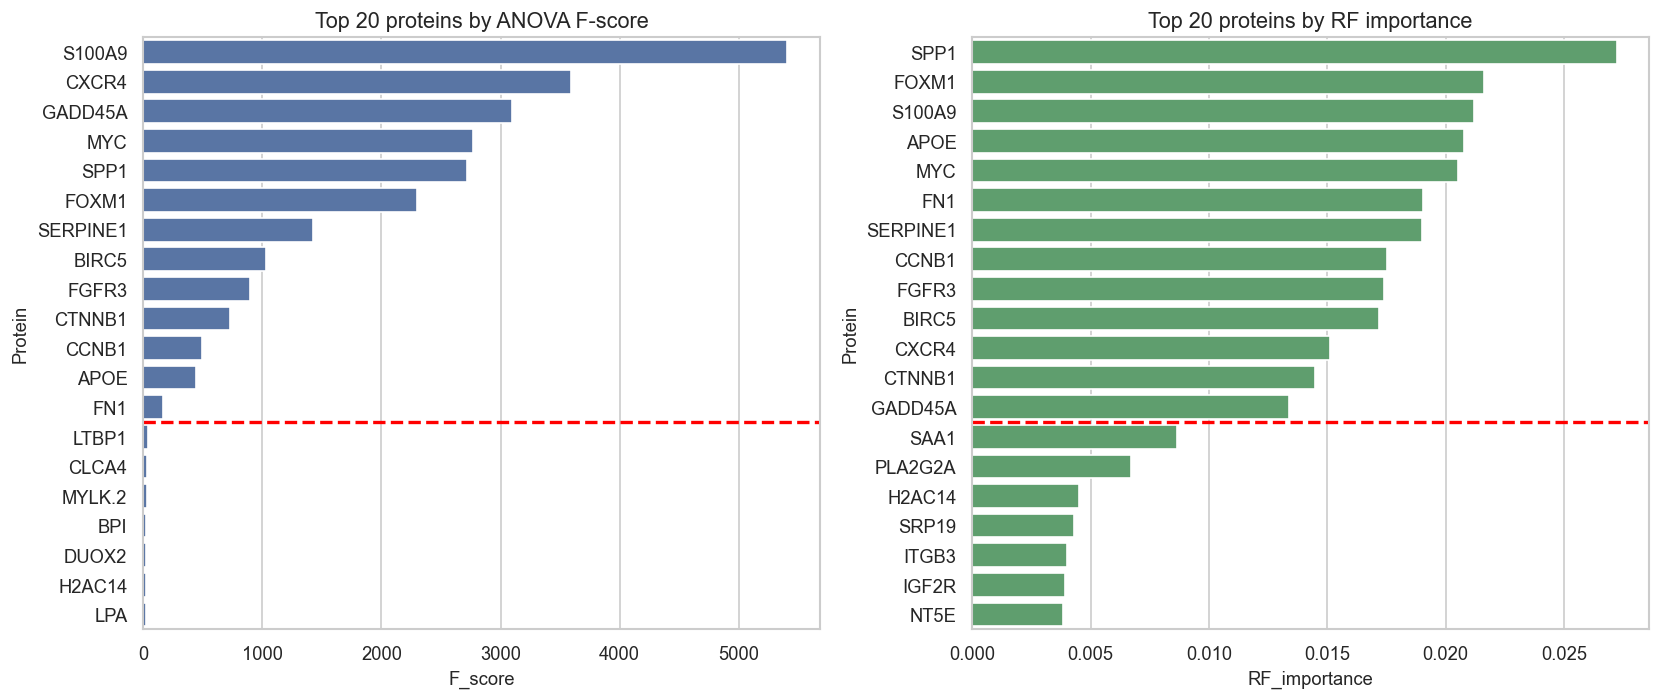

In [10]:

# Ensure both tables are independently sorted
anova_plot = anova_table.sort_values("F_score", ascending=False).head(20)
rf_plot = rf_table.sort_values("RF_importance", ascending=False).head(20)

cut_k = k_star
yline = cut_k - 0.5

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- ANOVA ---
sns.barplot(
    data=anova_plot,
    x="F_score",
    y="Protein",
    color="#4C72B0",
    ax=axes[0]
)
axes[0].axhline(
    y=yline,
    color="red",
    linestyle="--",
    linewidth=2
)
axes[0].set_title("Top 20 proteins by ANOVA F-score")

# --- RF ---
sns.barplot(
    data=rf_plot,
    x="RF_importance",
    y="Protein",
    color="#55A868",
    ax=axes[1]
)
axes[1].axhline(
    y=yline,
    color="red",
    linestyle="--",
    linewidth=2
)
axes[1].set_title("Top 20 proteins by RF importance")

plt.tight_layout()
plt.show()


#### 2.3.2 Subtype-wise Protein Expression Heatmap

A heatmap of subtype-averaged protein expression is used to visualize how selected proteins vary across tumor stages.  
Proteins are ordered in a data-driven manner to highlight stage-specific expression patterns and progression-related trends.


(<Figure size 1200x720 with 2 Axes>,
 <Axes: title={'center': 'Cluster Mean Expression (Top Selected Proteins)'}>)

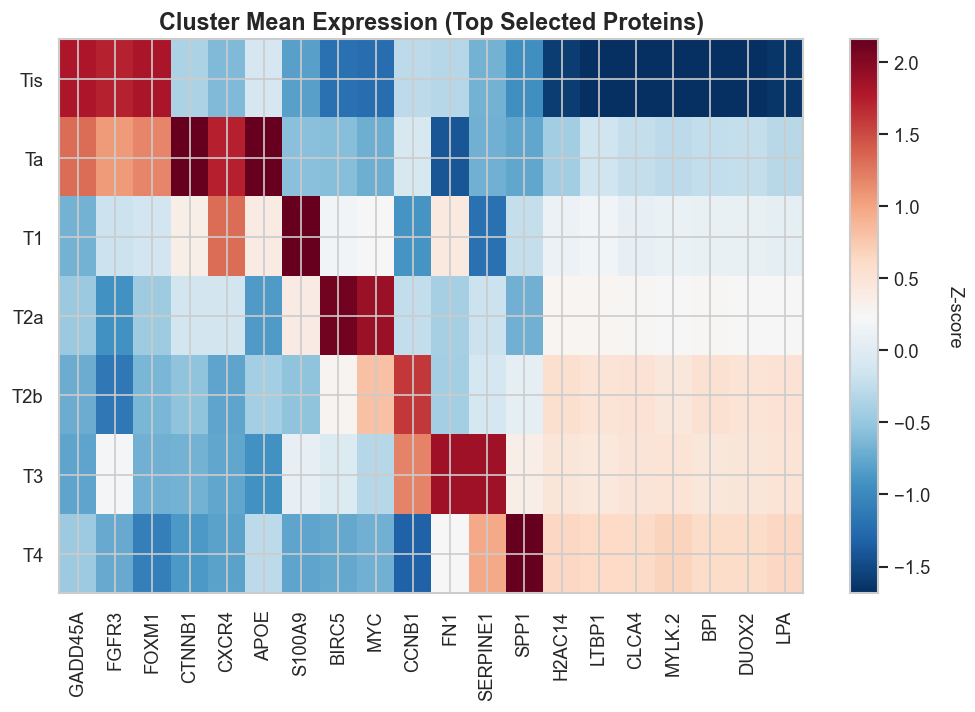

In [11]:

# ----- Data-driven protein ordering by stage progression -----

top_n = max(20, k_star)
X_var, _ = variance_filter(X_scaled, percentile=best_p)

# Protein column instead of index
heat_features = final_table["Protein"].head(top_n).tolist()

cluster_means = (
    pd.DataFrame(X_var, index=common_ids)
    .groupby(labels, observed=True)
    .mean()
)
cluster_means = cluster_means.loc[label_order, heat_features]

# --------------------------------------------------
# data-driven column ordering by peak stage
# --------------------------------------------------

# Map stage to numeric order (early → late)
stage_to_idx = {stage: i for i, stage in enumerate(cluster_means.index)}
# For each protein, find the stage where expression is maximal
protein_peak_stage = cluster_means.idxmax(axis=0)
# Convert peak stage to numeric index
protein_peak_idx = protein_peak_stage.map(stage_to_idx)
# Sort proteins by their peak stage (early → late)
protein_order = protein_peak_idx.sort_values().index.tolist()
# Reorder columns
cluster_means = cluster_means[protein_order]

# --------------------------------------------------
# Plot heatma
# --------------------------------------------------

plot_heatmap(
    cluster_means,
    row_labels=cluster_means.index.tolist(),
    col_labels=cluster_means.columns.tolist(),
    title="Cluster Mean Expression (Top Selected Proteins)",
    figsize=(10, 6),
    cluster_rows=False,
    cluster_cols=False,
    cbar_label="Z-score"
)


### Results interpretation and conclusion

Key takeaways from this analysis:
- Variance filtering combined with ANOVA F-scores and Random Forest importance identifies a compact and stable protein set that discriminates tumor subtypes.
- ANOVA and Random Forest rankings are highly consistent, highlighting shared high-impact proteins (e.g., S100A9, CXCR4, GADD45A, MYC, SPP1, FOXM1, SERPINE1), which increases confidence in the selected features.
- The subtype-mean heatmap reveals structured expression patterns across stages: early subtypes (Tis/Ta/T1) show distinct expression blocks, while advanced subtypes (T2b–T4) exhibit coordinated shifts toward higher expression in a subset of proteins.
- The final selected feature set captures both statistical significance and predictive relevance.
- Biologically, the observed expression gradients suggest a proteomic signature associated with tumor progression and aggressive disease behavior.


# 3. Metadata Evaluation

In this section, we assess whether the proteins identified in Level 2 are associated with clinical and outcome-related metadata.  
Unlike Level 1, where metadata was used to validate subtype structure, the goal here is to examine **direct associations between protein expression and clinical variables**.

Three complementary analyses are performed depending on the metadata type:
- Continuous variables (e.g., tumor size)
- Binary variables (e.g., survival status)
- Multiclass variables (e.g., treatment response)

All analyses are conducted on the final Level 2 protein set and corrected for multiple testing.


3.1 Prepare metadata alignment

In [12]:
# shared setup
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, mannwhitneyu, kruskal

# Use Level 2 protein set
protein_set = (
    consensus_proteins
    if "consensus_proteins" in globals() and len(consensus_proteins) > 0
    else final_table["Protein"].head(20).tolist()
)

# Expression matrix (already z-scored)
X_expr = pd.DataFrame(X_scaled, index=pca_full.index)[protein_set]

# Aligned metadata
meta = metadata.loc[pca_full.index].copy()


## 3.1 Protein Associations with Continuous Metadata

For continuous clinical variables, Spearman rank correlation is used to assess monotonic relationships between protein expression and metadata.


In [13]:
# Continuous metadata
# Spearman correlation (Tumor Size)
y = meta["Tumor_Size_mm"].astype(float)

records = []
for prot in protein_set:
    r, p = spearmanr(X_expr[prot], y, nan_policy="omit")
    records.append({
        "Protein": prot,
        "Spearman_r": r,
        "p_value": p
    })

corr_table = pd.DataFrame(records)
corr_table["q_value"] = benjamini_hochberg(corr_table["p_value"].values)
corr_table = corr_table.sort_values("q_value")

display(corr_table)



,Protein,Spearman_r,p_value,q_value
7,FOXM1,-0.875173,2.362655e-45,3.071452e-44
12,SPP1,0.831182,5.376537e-37,3.494749e-36
11,SERPINE1,0.717521,1.989706e-23,8.622058e-23
3,CTNNB1,-0.619837,3.202828e-16,1.040919e-15
0,APOE,-0.534065,1.081058e-11,2.810750e-11
5,FGFR3,-0.527521,2.131964e-11,4.619256e-11
4,CXCR4,-0.518007,5.578049e-11,1.035923e-10
8,GADD45A,-0.512087,9.999190e-11,1.624868e-10
6,FN1,0.406503,6.241045e-07,9.014843e-07
9,MYC,0.247614,3.181662e-03,4.136161e-03


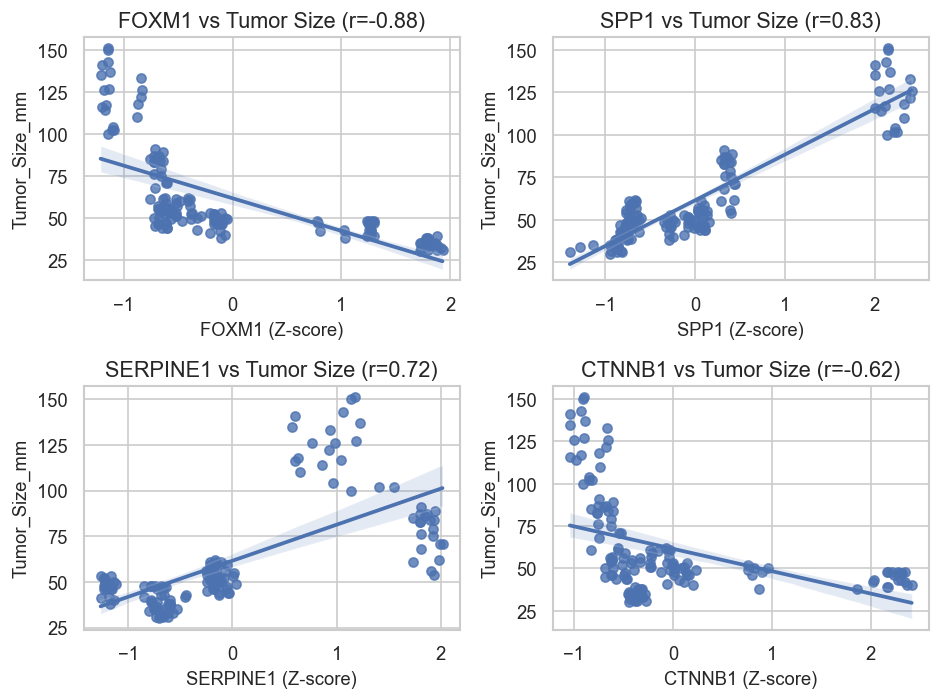

In [14]:
# Visualization (top correlated proteins)
top_corr = corr_table.head(4)["Protein"].tolist()
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for ax, prot in zip(axes, top_corr):
    sns.regplot(
        x=X_expr[prot],
        y=y,
        scatter_kws={"s": 30},
        ax=ax
    )
    r = corr_table.set_index("Protein").loc[prot, "Spearman_r"]
    ax.set_title(f"{prot} vs Tumor Size (r={r:.2f})")
    ax.set_xlabel(f"{prot} (Z-score)")
    ax.set_ylabel("Tumor_Size_mm")

plt.tight_layout()
plt.show()


Brief summary:

The top four proteins show strong monotonic associations with tumor size. 

- FOXM1 and CTNNB1 are negatively correlated with tumor size, indicating higher expression in early-stage, smaller tumors.
- SPP1 and SERPINE1 display positive correlations consistent with tumor progression. 
- These trends directly link the selected proteomic features to clinically relevant tumor burden at the patient level.

## 3.2 Protein Associations with Binary Metadata

For binary outcomes, differences in protein expression are evaluated using the Mann–Whitney U test.


In [15]:
# Mann–Whitney (Survival Status)
g = meta["Survival_Status"].astype(str)
mask_surv = g == "Survived"
mask_dead = g == "Deceased"

records = []
for prot in protein_set:
    x1 = X_expr.loc[mask_surv, prot].dropna()
    x2 = X_expr.loc[mask_dead, prot].dropna()
    if len(x1) < 3 or len(x2) < 3:
        continue
    stat, p = mannwhitneyu(x1, x2, alternative="two-sided")
    records.append({
        "Protein": prot,
        "p_value": p,
        "Median_diff": x2.median() - x1.median()
    })

mw_table = pd.DataFrame(records)
mw_table["q_value"] = benjamini_hochberg(mw_table["p_value"].values)
mw_table = mw_table.sort_values("q_value")

display(mw_table)


,Protein,p_value,Median_diff,q_value
7,FOXM1,4.015788e-18,-1.701362,5.220524e-17
12,SPP1,2.389904e-14,1.023769,1.553437e-13
11,SERPINE1,6.482574e-13,1.269781,2.809115e-12
3,CTNNB1,1.302654e-12,-0.591724,4.233626e-12
4,CXCR4,9.865888e-12,-0.739853,2.565131e-11
5,FGFR3,1.555027e-10,-1.816373,3.369225e-10
0,APOE,2.397071e-09,-0.460289,4.451703e-09
8,GADD45A,3.691334e-09,-1.927134,5.998417e-09
9,MYC,2.135768e-03,0.379657,3.084999e-03
6,FN1,2.892420e-03,0.139118,3.760146e-03


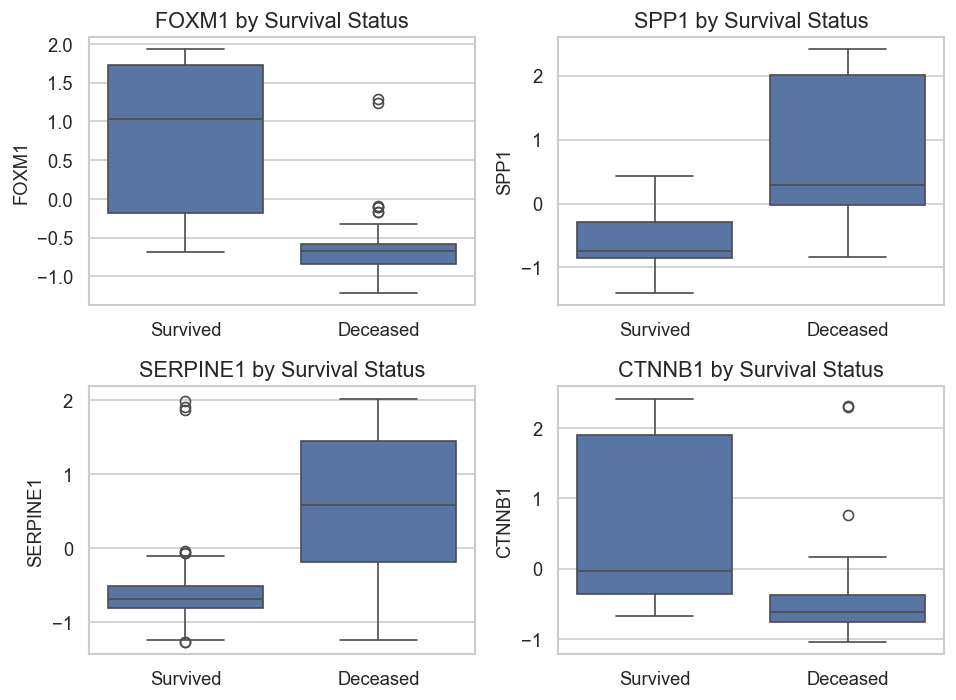

In [16]:
# Visualization (boxplots, top 4 proteins, 2x2 layout)

top_mw = mw_table.head(4)["Protein"].tolist()

plot_df = X_expr[top_mw].copy()
plot_df["Survival_Status"] = g.values

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for ax, prot in zip(axes, top_mw):
    sns.boxplot(
        data=plot_df,
        x="Survival_Status",
        y=prot,
        ax=ax
    )
    ax.set_title(f"{prot} by Survival Status")
    ax.set_xlabel("")
    ax.set_ylabel(prot)

plt.tight_layout()
plt.show()


### 3.3 Protein Associations with Multiclass Metadata

For categorical metadata with more than two levels, the Kruskal–Wallis test is applied to detect differences in protein expression across groups.


In [17]:
# Kruskal–Wallis (Treatment Response)
group = meta["Response_to_Treatment"].astype(str)

records = []
for prot in protein_set:
    groups = [
        X_expr.loc[group == lvl, prot].dropna()
        for lvl in group.unique()
        if (group == lvl).sum() >= 3
    ]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    records.append({
        "Protein": prot,
        "p_value": p
    })

kw_table = pd.DataFrame(records)
kw_table["q_value"] = benjamini_hochberg(kw_table["p_value"].values)
kw_table = kw_table.sort_values("q_value")

display(kw_table)


,Protein,p_value,q_value
7,FOXM1,4.413400e-18,5.737419e-17
5,FGFR3,1.076717e-16,6.998657e-16
12,SPP1,3.166953e-16,1.372346e-15
8,GADD45A,3.275076e-15,1.064400e-14
9,MYC,1.870569e-14,4.863479e-14
1,BIRC5,2.772240e-14,6.006520e-14
10,S100A9,1.965152e-12,3.649569e-12
2,CCNB1,6.827536e-07,1.109475e-06
0,APOE,1.770500e-06,2.301649e-06
3,CTNNB1,1.709638e-06,2.301649e-06


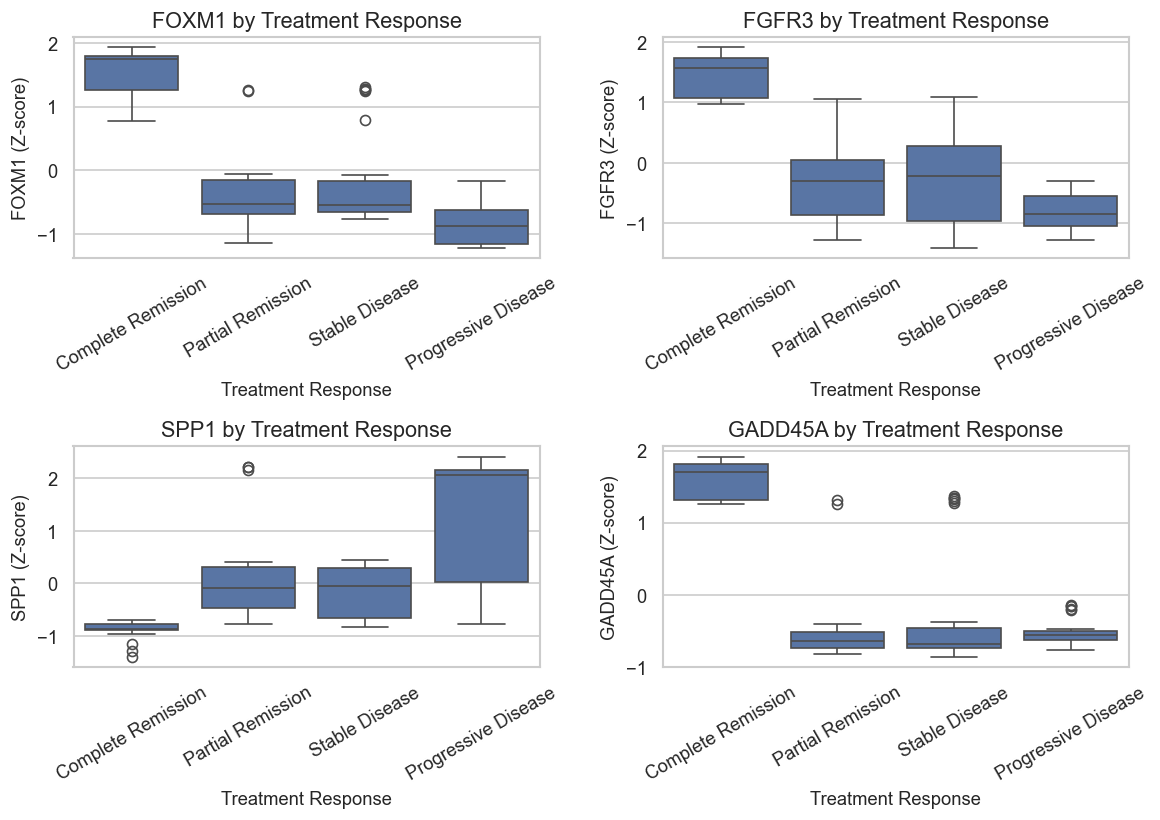

In [18]:
# Visualization (boxplots, 2x2)
top_kw = kw_table.head(4)["Protein"].tolist()

plot_df = X_expr[top_kw].copy()
plot_df["Response_to_Treatment"] = group.values

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for ax, prot in zip(axes, top_kw):
    sns.boxplot(
        data=plot_df,
        x="Response_to_Treatment",
        y=prot,
        order=["Complete Remission", "Partial Remission", "Stable Disease", "Progressive Disease"],
        ax=ax
    )
    ax.set_title(f"{prot} by Treatment Response")
    ax.set_xlabel("Treatment Response")
    ax.set_ylabel(f"{prot} (Z-score)")
    ax.tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


The boxplots show clear survival-associated expression shifts for the top proteins.

FOXM1 and CTNNB1 are higher in survived patients, while SPP1 and SERPINE1 are elevated in deceased patients.

This consistent separation suggests these proteins capture prognostic information beyond tumor stage alone.